In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 6.9 MB/s eta 0:00:00


In [19]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast

device = torch.device("cuda")

<h1>Load dataset</h1>

In [20]:
raw_df = pd.read_csv("train.En.csv")
df = raw_df.loc[:, ['tweet', 'sarcastic']]
print(df.head(), "\n")
print("shape: ", df.shape, "\n")
print("class distribution: ", df['sarcastic'].value_counts(normalize = True))

test_df = pd.read_csv("task_A_En_test.csv")
print(test_df.head())


                                               tweet  sarcastic
0  The only thing I got from college is a caffein...          1
1  I love it when professors draw a big question ...          1
2  Remember the hundred emails from companies whe...          1
3  Today my pop-pop told me I was not “forced” to...          1
4  @VolphanCarol @littlewhitty @mysticalmanatee I...          1 

shape:  (3468, 2) 

class distribution:  0    0.75
1    0.25
Name: sarcastic, dtype: float64
                                                text  sarcastic
0  Size on the the Toulouse team, That pack is mo...          0
1                                           Pinball!          0
2  So the Scottish Government want people to get ...          1
3  villainous pro tip : change the device name on...          0
4                    I would date any of these men 🥺          0


<h1>Preprocess the data</h1>

In [21]:
df['tweet'] = df['tweet'].astype(str)
test_df['text'] = test_df['text'].astype(str)

<h1>Splitting the training data into 90% training and 10% validation</h1>

In [22]:
train_text, valid_text, train_labels, valid_labels = train_test_split(df['tweet'], df['sarcastic'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df['sarcastic'])

<h1>Importing BERT Model / BERT Tokenizer</h1>

In [23]:
bert = AutoModel.from_pretrained('bert-base-uncased', return_dict=False)

tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [24]:
# testing out how sent ids work
text = ["the cow jumped over the moon", "the fox jumped over the moon and jumped back"]

sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

print(sent_id)

# attention masks do not capture padding values, padding is added when one input is larger than the other

{'input_ids': [[101, 1996, 11190, 5598, 2058, 1996, 4231, 102, 0, 0, 0], [101, 1996, 4419, 5598, 2058, 1996, 4231, 1998, 5598, 2067, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

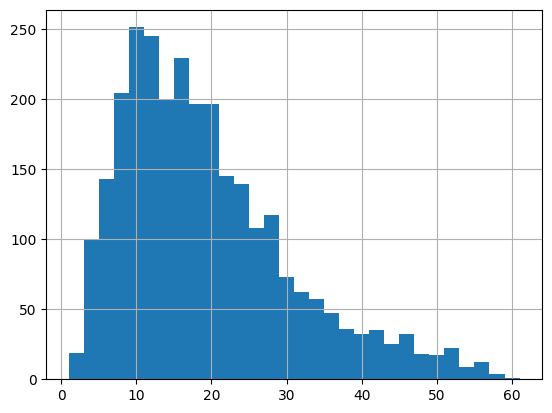

In [25]:
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins=30)

In [26]:
max_seq_len = 25

<h1>Tokenize data</h1>

In [27]:
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_val = tokenizer.batch_encode_plus(
    valid_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

tokens_test = tokenizer.batch_encode_plus(
    test_df['text'].tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


<h1>Convert integer sequences to tensors</h1>

In [28]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(valid_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_df['sarcastic'].tolist())

In [29]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_data = TensorDataset(train_seq, train_mask, train_y) # wrap tensors
train_sampler = RandomSampler(train_data) # used for sampling in training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) # dataloader

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data) # used for sampling in validation
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [30]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [31]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
        super(BERT_Arch, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(0.1)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(768, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 2)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sent_id, mask):
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [32]:
if torch.cuda.is_available():
    device = torch.device("cuda")          
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print(f'The current device is {torch.cuda.get_device_name(0)}')
else:
    print('CUDA is not available. Using CPU...')
    device = torch.device("cpu")

model = BERT_Arch(bert)

model = model.to(device)

CUDA is not available. Using CPU...


In [33]:
from sklearn.utils.class_weight import compute_class_weight

class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.66682692 1.99855908]


In [34]:
# class weights to sensors
weights = torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

cross_entropy = nn.NLLLoss(weight=weights) # loss function

# number of training epochs
epochs = 20
     

In [35]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9) # optimizer

<h1>Fine-Tuning BERT</h1>
<p>In this cell we are saving the model predictions while iterating over batches. For each batch, we clear the previously calculated gradients and get the model's predictions for the current batch. We then calculate the loss between the actual and predicted values which is added to the total loss. We then backward pass to calculate the gradients and clip the gradients to 1.0 which helps to prevent exploding gradients. Finally, we update the parameters and append the predictions to a list of stored predictions.</p>

In [39]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0
  total_preds=[]
  
  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()        
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()
    total_preds.append(preds)

  avg_loss = total_loss / len(train_dataloader)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

<h1>Evaluating the model</h1>
<p>In this cell we are computing the validation loss between the actual and predicted loss.</p>

In [40]:
# function for evaluating the model
def evaluate():
  print("\nEvaluating...")
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  total_preds = []

  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:
      elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
      total_preds.append(preds)

  avg_loss = total_loss / len(val_dataloader) 
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

<h1>Model training</h1>
Here we are training, evaluating and saving the best model.

In [41]:
best_valid_loss = float('inf')

train_losses=[]
valid_losses=[]

for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    train_loss, _ = train()
    
    valid_loss, _ = evaluate()
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 20
  Batch    50  of     87.

Evaluating...

Training Loss: 0.694
Validation Loss: 0.694

 Epoch 2 / 20
  Batch    50  of     87.


KeyboardInterrupt: ignored

In [ ]:
# load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [ ]:
from sklearn.metrics import classification_report, f1_score
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))
macro_f1 = f1_score(test_y, preds, average='macro')
weighted_f1 = f1_score(test_y, preds, average='weighted')
print(macro_f1, weighted_f1)

              precision    recall  f1-score   support

           0       0.84      0.82      0.83      1200
           1       0.07      0.08      0.07       200

    accuracy                           0.72      1400
   macro avg       0.46      0.45      0.45      1400
weighted avg       0.73      0.72      0.72      1400

0.45324305759984296 0.723831952563186
